# Chong Zhen Jie A0201613Y
---
# Assignment Question 5: Movie Lens

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
sns.set_theme(font_scale=1.5)
SEED = 5232

### 5(i) Loading of data

In [4]:
col_names = ["user_id", "movie_id", "ratings"]
filepath = "data\data.csv"

data = pd.read_csv(filepath, names=col_names)
print(f"Size of dataset: {data.shape}")

data.head()

Size of dataset: (100000, 3)


,user_id,movie_id,ratings
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


### 5(ii) Random train-test split

In [5]:
np.random.seed(SEED)

# Create boolean mask
rand = np.random.rand(len(data))
mask = rand <= np.percentile(rand, 90) 

# Index dataset based on boolean mask
train = data.iloc[mask]
test = data.iloc[~mask]

print(f"Size of training dataset: {train.shape}")
print(f"Size of testing dataset: {test.shape}")

Size of training dataset: (90000, 3)
Size of testing dataset: (10000, 3)


### 5(iii) Baseline estimator

##### Exploratory data analysis

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,100000.0,462.48475,266.614420,1.0,254.0,447.0,682.0,943.0
movie_id,100000.0,425.53013,330.798356,1.0,175.0,322.0,631.0,1682.0
ratings,100000.0,3.52986,1.125674,1.0,3.0,4.0,4.0,5.0


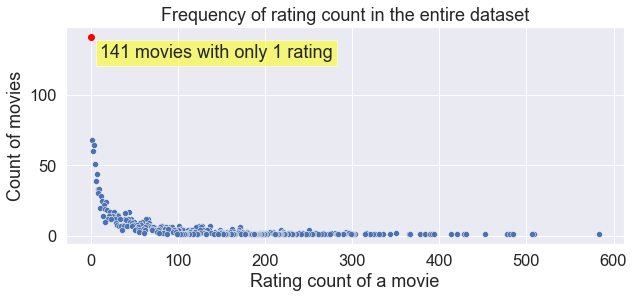

In [7]:
movie_counts = data["movie_id"].value_counts() # Counts total ratings for each movie
rating_freq = movie_counts.value_counts() # Counts the frequency of each unique total ratings
min_ratings = rating_freq.min()

# Scatterplot
plt.figure(figsize=(10,4))
sns.scatterplot(x=rating_freq.index, y=rating_freq.values)
plt.scatter(min_ratings, rating_freq.loc[min_ratings], color="red")
plt.text(min_ratings+10, rating_freq.loc[min_ratings]-15,
         s=f"{rating_freq.loc[min_ratings]} movies with only {min_ratings} rating",
         bbox=dict(facecolor="yellow",alpha=0.5))
plt.ylabel("Count of movies")
plt.xlabel("Rating count of a movie")
plt.title("Frequency of rating count in the entire dataset")

plt.show()

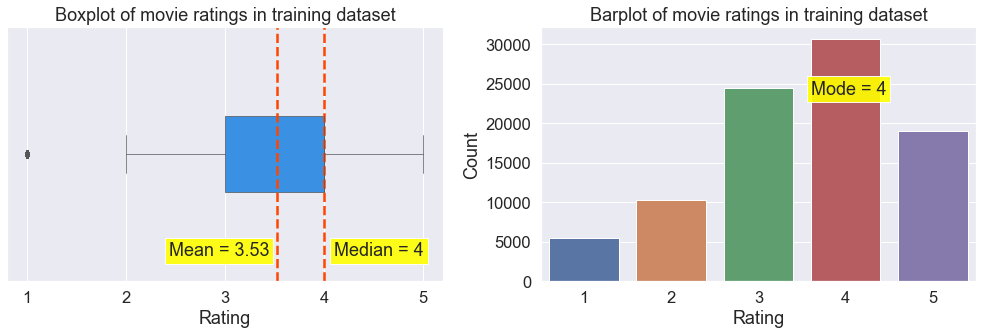

In [8]:
rating_col = train["ratings"]
median_rating, mean_rating, mode_rating = int(rating_col.median()), rating_col.mean(), rating_col.mode()[0]
rating_counts = rating_col.value_counts() # Counts number of ratings for each integer value

plt.figure(figsize=(14,5))
# Boxplot
plt.subplot(1,2,1)
sns.boxplot(x=rating_col, color="dodgerblue", width=0.3, linewidth=.7)
plt.axvline(median_rating, color="orangered", ls="--", lw=2.5)
plt.axvline(mean_rating, color="orangered", ls="--", lw=2.5)
plt.text(median_rating + .1, .4, s=f"Median = {median_rating}", bbox=dict(facecolor="yellow",alpha=0.9))
plt.text(mean_rating - 1.1, .4, s=f"Mean = {mean_rating:.2f}", bbox=dict(facecolor="yellow",alpha=0.9))
plt.xlabel("Rating")
plt.xticks([i for i in range(1,6)])
plt.title("Boxplot of movie ratings in training dataset")

# Barplot
plt.subplot(1,2,2)
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.text(mode_rating-1.4, rating_counts.max()-7000, s=f"Mode = {mode_rating}", bbox=dict(facecolor="yellow",alpha=.9))
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Barplot of movie ratings in training dataset")

plt.tight_layout()
plt.show()

##### Building baseline estimator

In [9]:
# Compute predictions of baseline estimator
base_pred = train.groupby("movie_id").mean()[["ratings"]].reset_index().rename(columns={"ratings": "base_pred"})

# Merge testing data with predictions using left-join
baseline = test.merge(base_pred, how="left", on="movie_id")
print(f"Number of missing entries in baseline predictions: {baseline.isna().sum().sum()}")

# Fill NA values with the median rating in training dataset
baseline["base_pred"] = baseline["base_pred"].fillna(median_rating)
print(f"Number of missing entries after filling NA values: {baseline.isna().sum().sum()}")

baseline.head()

Number of missing entries in baseline predictions: 13
Number of missing entries after filling NA values: 0


,user_id,movie_id,ratings,base_pred
0,305,451,3,3.328947
1,200,222,5,3.674772
2,97,194,3,4.072398
3,25,181,5,3.975281
4,279,154,5,3.700000


##### Evaluation metric: root-mean-squared error (RMSE)

In [10]:
# Define function to compute RMSE
def compute_RMSE(pred, test=test):
    """
    Args:
    ===
    pred: Predicted ratings
    test: Testing dataset
    
    Output:
    ===
    Return RMSE.
    """
    # Extract actual ratings
    actual = test["ratings"].to_numpy()
    
    # Convert to integers due to integer constraint
    pred = np.round(pred)
    
    # Evaluate metric
    val = np.mean(np.power(actual-pred, 2)) ** 0.5
    
    return val

##### Results of baseline estimator

In [11]:
# Compute RMSE for baseline estimator
baseline_RMSE = compute_RMSE(baseline["base_pred"].to_numpy())

print(f"RMSE of baseline estimator: {baseline_RMSE:.4f}")

RMSE of baseline estimator: 1.0599


### 5(iv) Matrix completion algorithm

In [13]:
# Size of X is m by n
m, n = data["user_id"].nunique(), data["movie_id"].nunique()

# Initialize zero matrix
X_init = np.zeros(shape=(m,n))

print(f"Size of X: {X_init.shape}")

Size of X: (943, 1682)


In [14]:
# Define function for matrix completion algorithm
def mat_com_algo(r, niter=200, X_init=X_init, train=train, test=test):
    """
    Args:
    ===
    r: rank-r approximation of X
    niter: Number of iterations to run the algorithm
    X_init: Initial value of X
    train: Training dataset
    test: Testing dataset
    
    Output:
    ===
    Return the list of errors and predicted ratings.
    """
    errors = []
    
    # Set X to initial value
    X = X_init
    
    for _ in range(niter):
        # (a) Set entries to correspond to training dataset
        X[train["user_id"]-1, train["movie_id"]-1] = train["ratings"]
        
        # (b) Compute SVD of X
        U, S, V_T = np.linalg.svd(X, full_matrices=False)
        
        # (c) Set all but the first r singular values to be zero
        S_new = S.copy()
        S_new[r:] = 0
        
        # (d) Compute low rank approximation of X with rank = r
        X_new = U @ np.diag(S_new) @ V_T
        
        # (e) Record error, defined by frobenius norm of the matrix difference
        err = X - X_new
        err = np.linalg.norm(err, ord="fro")
        errors.append(err)
        
        # (f) Set X to be the new approximated X
        X = X_new
    
    # Clip the values
    X = np.clip(X, a_min=1, a_max=5)
    
    # Extract predicted ratings
    pred = X[test["user_id"]-1, test["movie_id"]-1]
    
    return errors, pred

### 5(v) Testing the algorithm at $r=10$

In [15]:
# Run algorithm at r=10
r = 10
errors_10, pred_10 = mat_com_algo(r)

In [16]:
# Define function for plot customizations
def plot_custom(title):
    plt.xlabel("Iteration")
    plt.ylabel("Error")
#     plt.yscale("log")
    plt.title(title)

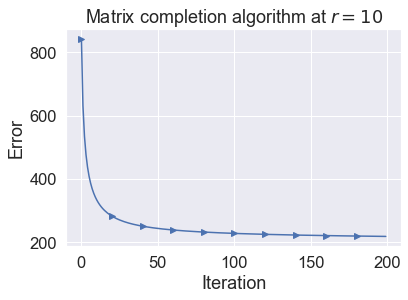

In [17]:
# Plot errors for matrix completion at r=10
plt.plot(errors_10, "->", markevery=20)
plot_custom(f"Matrix completion algorithm at $r={r}$")

plt.show()

In [18]:
# Compute evaluation metric for algorithm at r=10
RMSE_10 = compute_RMSE(pred_10)

print(f"RMSE of algorithm at r=10: {RMSE_10:.4f}")

RMSE of algorithm at r=10: 1.0465


### 5(vi) Results of algorithm for all $r=1,...,20$

In [19]:
################################
### Around 40 minutes to run ###
################################

# Run algorithm for r=1,...,20
results = list( map(mat_com_algo, tqdm(range(1,21), desc="Progress bar")) )

Progress bar: 100%|███████████████████████████████████████████████████████████████████| 20/20 [40:20<00:00, 121.02s/it]


In [20]:
errors_list = [i[0] for i in results]
pred_list = [i[1] for i in results]

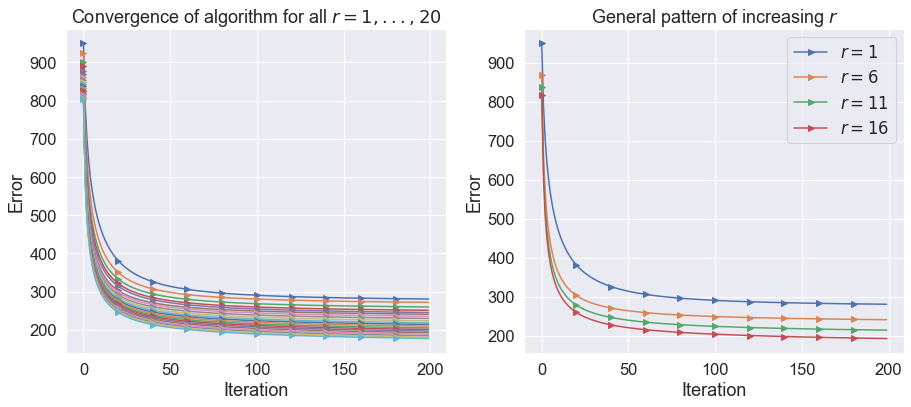

In [21]:
# Plot errors for all r=1,...,20
plt.figure(figsize=(13,6))
for i in range(len(errors_list)):
    plt.subplot(1,2,1)
    plt.plot(errors_list[i], "->", markevery=20)
    plot_custom("Convergence of algorithm for all $r=1,...,20$")
    if i%5 == 0:
        plt.subplot(1,2,2)
        plt.plot(errors_list[i], "->", markevery=20, label=f"$r={i+1}$")
        plt.legend()
        plot_custom("General pattern of increasing $r$")
        
plt.tight_layout()
plt.show()

In [22]:
# Collate RMSE together with the corresponding rank parameter r
RMSE_list = [compute_RMSE(pred) for pred in pred_list]
RMSE_df = pd.DataFrame({"r": [f"{i}" for i in range(1,21)], "RMSE": RMSE_list}).set_index("r")

RMSE_df.T

r,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
RMSE,1.006032,1.002996,0.986864,0.98904,0.99965,1.001948,1.016858,1.019804,1.035809,1.04647,1.055746,1.068644,1.078239,1.08821,1.099955,1.111935,1.124633,1.135562,1.151217,1.160517


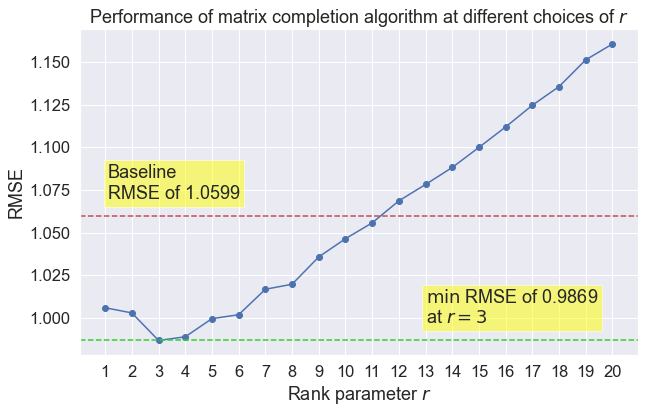

In [23]:
# Plot RMSE against r
plt.figure(figsize=(10,6))
plt.plot(RMSE_df.index, RMSE_df["RMSE"], marker="o")

# Plot RMSE of baseline estimator as reference
plt.axhline(baseline_RMSE, ls="--", c="r")
plt.text(0.1, baseline_RMSE+0.01, s=f"Baseline\nRMSE of {baseline_RMSE:.4f}", bbox=dict(facecolor="yellow",alpha=.5))

# Plot reference horizontal line to indicate minimum RMSE
min_RMSE = RMSE_df["RMSE"].min()
min_r = RMSE_df[RMSE_df["RMSE"]==min_RMSE].index[0]
plt.axhline(min_RMSE, ls="--", c="limegreen")
plt.text(12, min_RMSE+0.01, s=f"$\min$ RMSE of {min_RMSE:.4f}\nat $r={min_r}$", bbox=dict(facecolor="yellow",alpha=.5))

plt.xlabel("Rank parameter $r$")
plt.ylabel("RMSE")
plt.title("Performance of matrix completion algorithm at different choices of $r$")

plt.show()

---